In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import os
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display, HTML


In [ ]:
# Charger les fichiers CSV
df_freMTPL = pd.read_csv("/home/onyxia/work/Federated_Learning_Milliman/data/french_data.csv")
df_freMTPL

,IdPolicy,ClaimAmount,ClaimNb,Exposure,power,CarAge,DriverAge,CarBrand,CarGas,Region,Density,Sex,Sinistre
0,33,302.00,1,0.75,43,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,0,0
1,41,2001.00,1,0.14,66,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56,1,1
2,92,1449.00,1,0.14,10,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792,1,1
3,96,1165.00,2,0.62,56,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,1,1
4,96,946.00,2,0.62,56,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42620,6113793,1769.88,1,0.14,7,2,51,B12,Diesel,Aquitaine,178,1,1
42621,6113817,1288.28,1,0.17,4,0,35,B12,Regular,Rhone-Alpes,1719,1,1
42622,6113834,1940.40,2,0.17,15,3,36,B12,Regular,Poitou-Charentes,181,0,1
42623,6113834,1165.00,2,0.17,15,3,36,B12,Regular,Poitou-Charentes,181,1,1


/tmp/ipykernel_47085/157607161.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["blue", "red"])


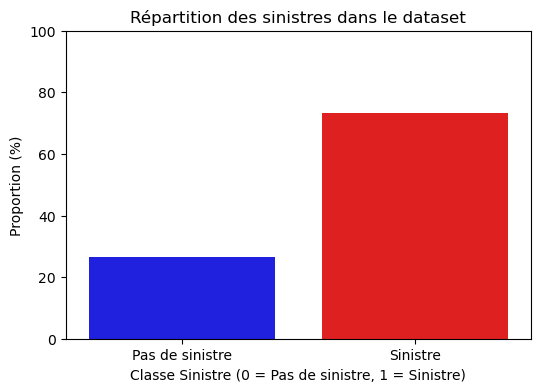

In [36]:
# Calcul de la proportion des sinistres
class_distribution = df_freMTPL["Sinistre"].value_counts(normalize=True) * 100

# Visualisation avec un graphique
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["blue", "red"])
plt.xlabel("Classe Sinistre (0 = Pas de sinistre, 1 = Sinistre)")
plt.ylabel("Proportion (%)")
plt.title("Répartition des sinistres dans le dataset")
plt.xticks([0, 1], ["Pas de sinistre", "Sinistre"])
plt.ylim(0, 100)
plt.show()


La classe 1 (Sinistre) est largement majoritaire. Dans ce genre de situation, l'accuracy n'est pas une métrique pertinente. D'autres métriques comme la précision, le rappel, ou la F-mesure sont souvent plus appropriées, car elles prennent en compte les performances du modèle sur les deux classes et non seulement sur la classe majoritaire.

## Correlation

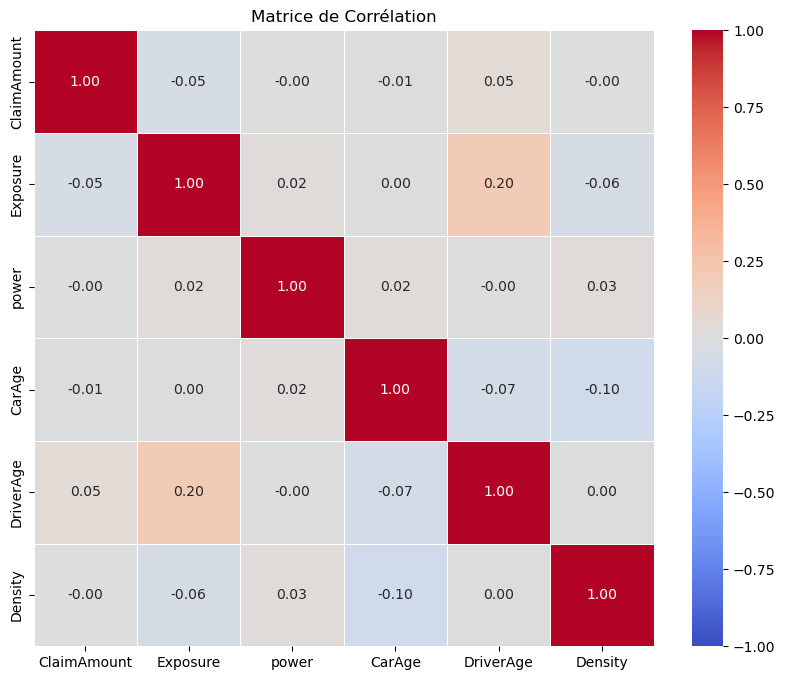

In [24]:

# Calcul de la matrice de corrélation pour les variables numériques
corr_matrix = df_freMTPL[['ClaimAmount', 'Exposure', 'power', 'CarAge', 'DriverAge', 'Density']].corr()

# Création de la carte de chaleur
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()


In [ ]:
def analyze_categorical_correlation(df_freMTPL, cat_vars=['CarBrand', 'CarGas', 'Region', 'Sex'], 
                                   alpha=0.05, figsize=(10, 8)):
   
    # Préparation des données
    cat_df = df_freMTPL[cat_vars].copy()
    for col in cat_df.select_dtypes(include='bool'):
        cat_df[col] = cat_df[col].astype(str)
    
    # Calcul des résultats
    results = []
    for i, var1 in enumerate(cat_vars[:-1]):
        for var2 in cat_vars[i+1:]:
            contingency_table = pd.crosstab(cat_df[var1], cat_df[var2])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            
            # Calcul du Cramer's V
            n = contingency_table.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))
            
            # Interprétation
            strength = "Très forte" if cramer_v >= 0.5 else \
                     "Forte" if cramer_v >= 0.3 else \
                     "Modérée" if cramer_v >= 0.1 else "Faible"
            
            results.append({
                'Paire de variables': f"{var1} - {var2}",
                'Cramer\'s V': cramer_v,
                'Force de la corrélation': strength,
                'p-value': p,
                'Significatif': p < alpha
            })
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame(results)
    
    # Style pour la visualisation
    def color_strength(val):
        color = 'white'
        if val == "Très forte": color = '#FF0000'  # Rouge
        elif val == "Forte": color = '#FF6666'     # Rouge clair
        elif val == "Modérée": color = '#FFCCCC'   # Rouge très clair
        return f'background-color: {color}'
    
    def color_pvalue(val):
        color = 'limegreen' if val < alpha else 'lightcoral'
        return f'color: {color}; font-weight: bold'
    
    # Application du style
    styled_df = results_df.style \
        .applymap(color_pvalue, subset=['p-value']) \
        .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral', 
                 subset=['Significatif']) \
        .applymap(color_strength, subset=['Force de la corrélation']) \
        .format({
            'Cramer\'s V': "{:.3f}",
            'p-value': "{:.4f}"
        }) \
        .set_caption("Résultats des tests de corrélation entre variables catégorielles") \
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12pt',
            'border': '1px solid black'
        })
    
    # Affichage dans Jupyter
    display(styled_df)
    return results_df

results = analyze_categorical_correlation(df_freMTPL)

/tmp/ipykernel_47085/687304509.py:71: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_47085/687304509.py:72: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_47085/687304509.py:74: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,CarBrand - CarGas,0.114,Modérée,0.0000,True
1,CarBrand - Region,0.145,Modérée,0.0000,True
2,CarBrand - Sex,0.024,Faible,0.0948,False
3,CarGas - Region,0.107,Modérée,0.0000,True
4,CarGas - Sex,0.001,Faible,0.7873,False
5,Region - Sex,0.021,Faible,0.6496,False


## Description des variables 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyse_variable_numerique(df, var_num, cible='Sinistre'):
    print(f"## Analyse de la variable numérique : {var_num}\n")
    
    # Stat descriptives globales et par classe
    display(df[[var_num]].describe())
    display(df.groupby(cible)[var_num].describe())

    # Boxplot par classe
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')
    plt.title(f'{var_num} selon {cible}')
    plt.grid(True)
    plt.show()

    # Distribution (histogramme/kde)
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=var_num, hue=cible, common_norm=False, fill=True)
    plt.title(f'Distribution de {var_num} selon {cible}')
    plt.grid(True)
    plt.show()

In [34]:
def analyse_variable_categorielle(df, var_cat, cible='Sinistre'):
    print(f"## Analyse de la variable catégorielle : {var_cat}\n")
    
    # Calcul du taux de sinistre + nombre d'observations + sinistres
    stats = df.groupby(var_cat).agg(
        Effectif=(cible, 'count'),
        Nombre_sinistres=(cible, 'sum'),
        Taux_de_sinistre=(cible, 'mean')
    ).sort_values(by='Taux_de_sinistre', ascending=False).reset_index()

    # Affichage stylisé
    display(stats.style
            .format({'Taux_de_sinistre': '{:.2%}'})
            .background_gradient(cmap='Reds', subset=['Taux_de_sinistre'])
            .set_caption(f"Taux de sinistre par '{var_cat}'"))

    # Diagramme en barres verticales
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=var_cat, hue=cible, palette='Set2')
    plt.title(f'Distribution de {var_cat} selon {cible}')
    plt.xticks(rotation=90)  # Modalités affichées verticalement
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


## Analyse de la variable numérique : ClaimAmount



,ClaimAmount
count,42625.000000
mean,972.481265
std,429.458657
min,1.000000
25%,689.000000
50%,1165.000000
75%,1204.000000
max,2059.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,338.636506,232.243510,1.00,92.415,315.47,564.06,770.36
1,31270.0,1202.647790,181.528116,770.54,1128.120,1165.00,1204.00,2059.00


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


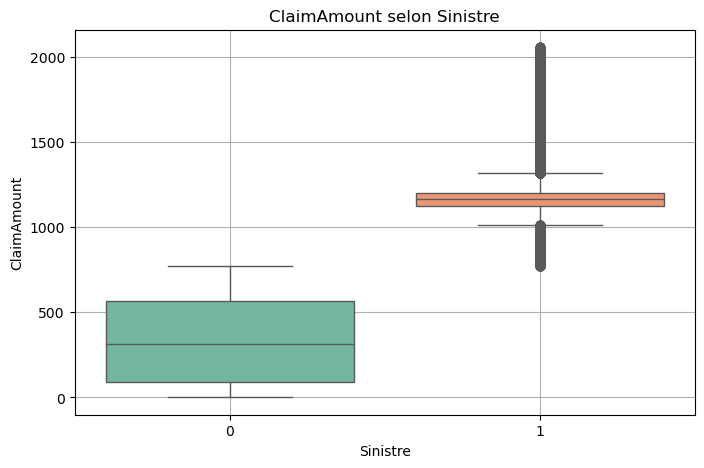

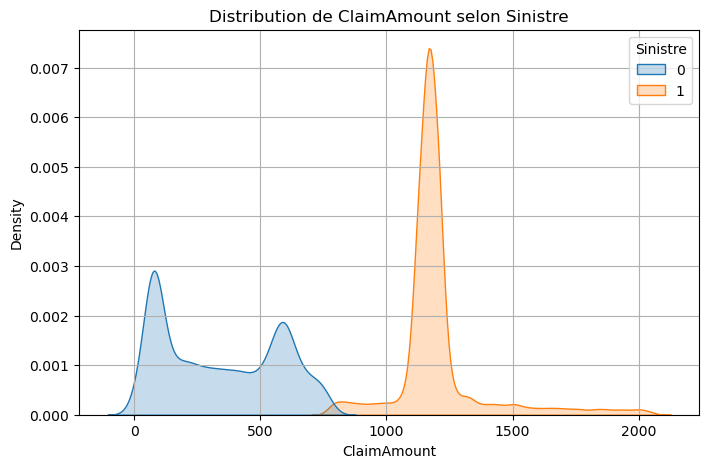

## Analyse de la variable numérique : Exposure



,Exposure
count,42625.000000
mean,0.697743
std,0.312923
min,0.002740
25%,0.450000
50%,0.780000
75%,1.000000
max,2.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,0.711295,0.310838,0.005464,0.47,0.81,1.0,2.00
1,31270.0,0.692822,0.313537,0.002740,0.44,0.77,1.0,1.28


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


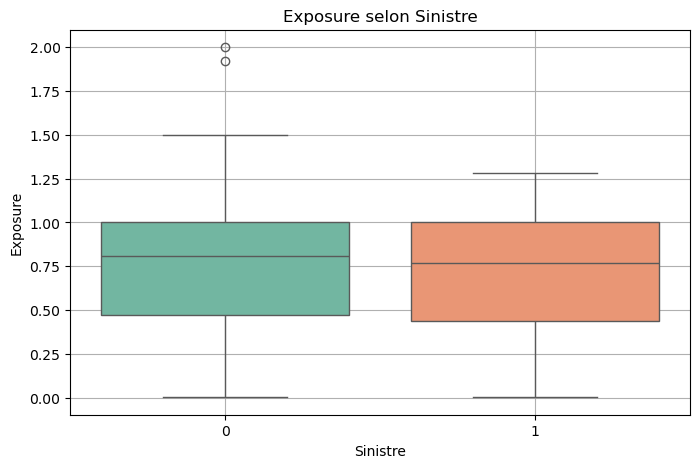

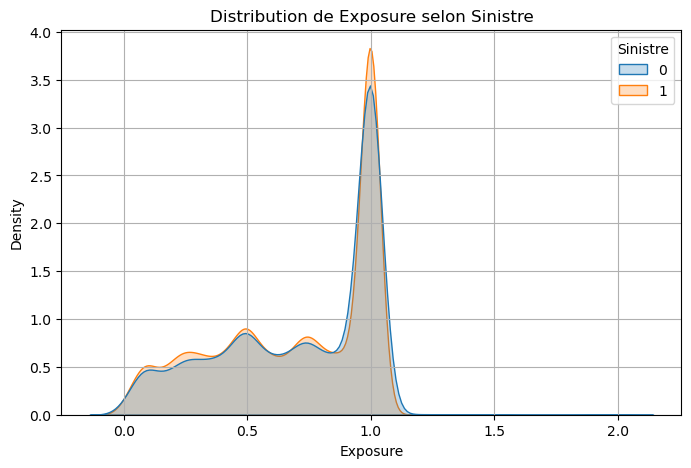

## Analyse de la variable numérique : power



,power
count,42625.000000
mean,18.277419
std,17.824671
min,4.000000
25%,6.000000
50%,8.000000
75%,30.000000
max,120.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,18.160898,17.906036,4.0,6.0,7.0,30.0,120.0
1,31270.0,18.319731,17.795132,4.0,6.0,8.0,40.0,120.0


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


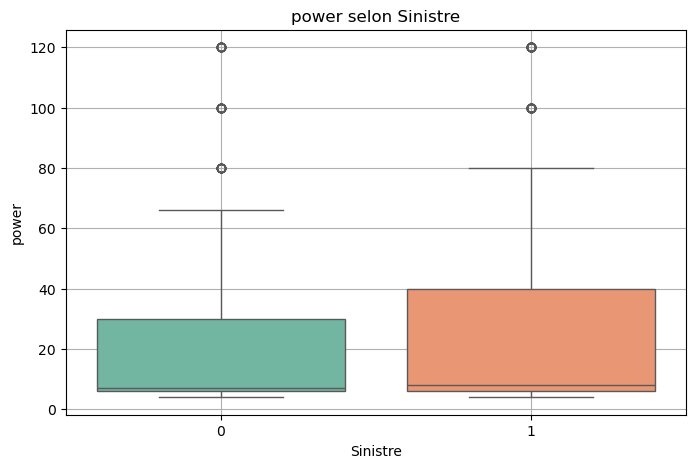

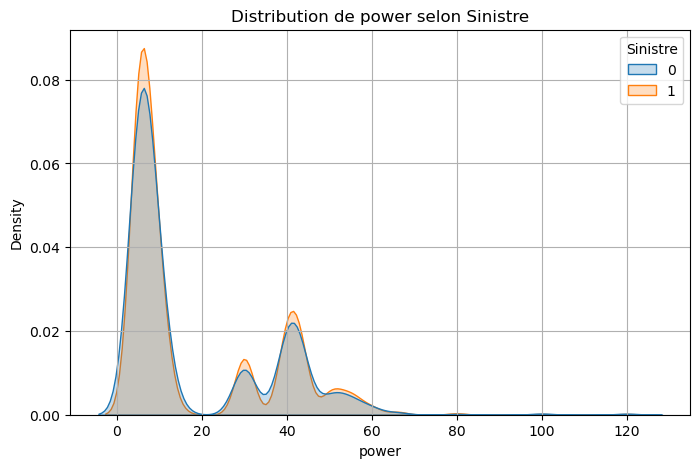

## Analyse de la variable numérique : CarAge



,CarAge
count,42625.000000
mean,7.473760
std,5.197558
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,99.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,7.396653,5.087741,0.0,3.0,7.0,11.0,69.0
1,31270.0,7.501759,5.236666,0.0,3.0,7.0,11.0,99.0


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


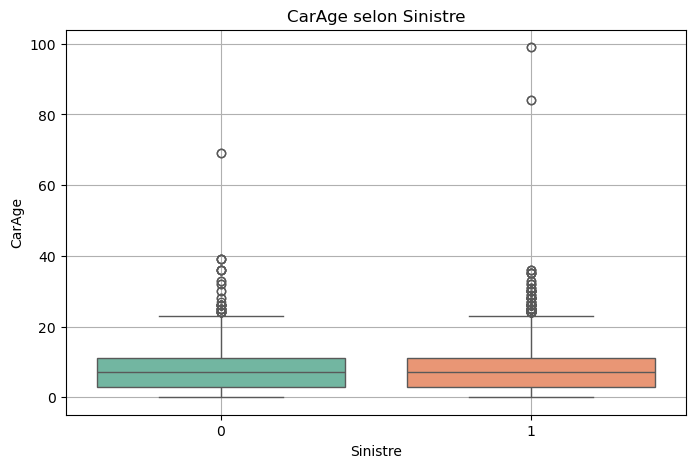

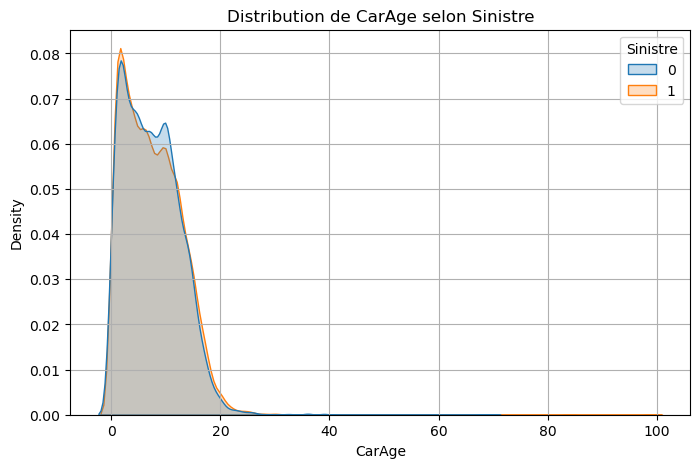

## Analyse de la variable numérique : DriverAge



,DriverAge
count,42625.000000
mean,45.023155
std,14.787152
min,18.000000
25%,34.000000
50%,44.000000
75%,54.000000
max,99.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,43.843945,14.063294,18.0,33.0,43.0,53.0,99.0
1,31270.0,45.451359,15.018706,18.0,34.0,45.0,55.0,99.0


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


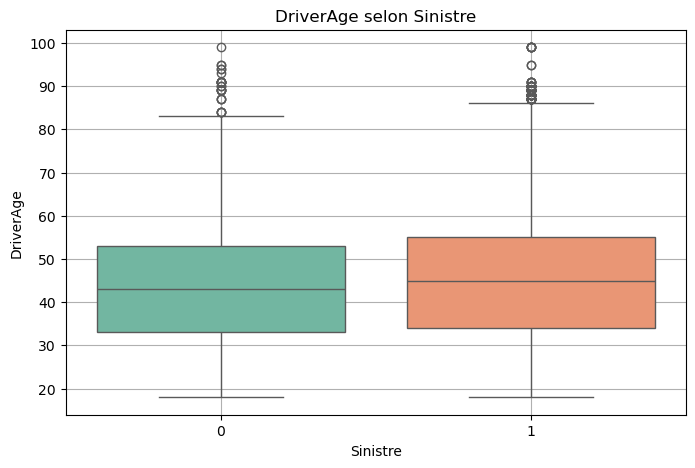

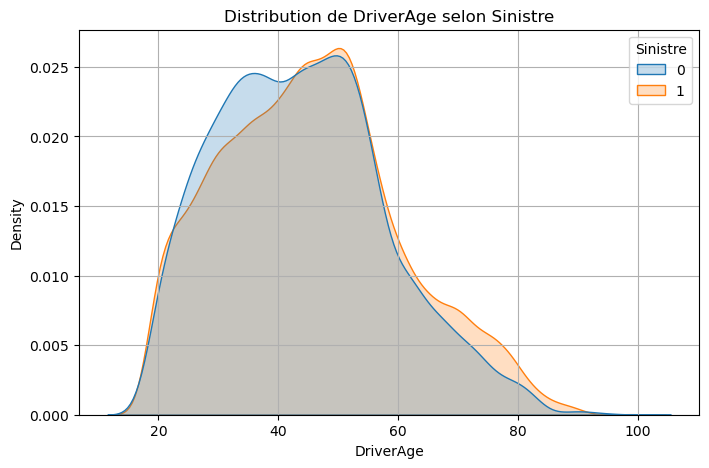

## Analyse de la variable numérique : Density



,Density
count,42625.000000
mean,2052.633947
std,4493.183193
min,2.000000
25%,101.000000
50%,461.000000
75%,1974.000000
max,27000.000000


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,11355.0,2193.160986,4749.365908,2.0,102.0,473.0,2103.0,27000.0
1,31270.0,2001.604701,4395.430246,2.0,99.0,453.5,1955.0,27000.0


/tmp/ipykernel_47085/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


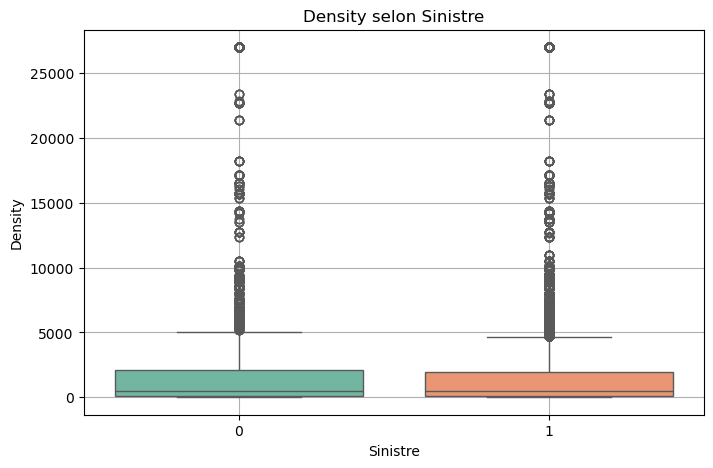

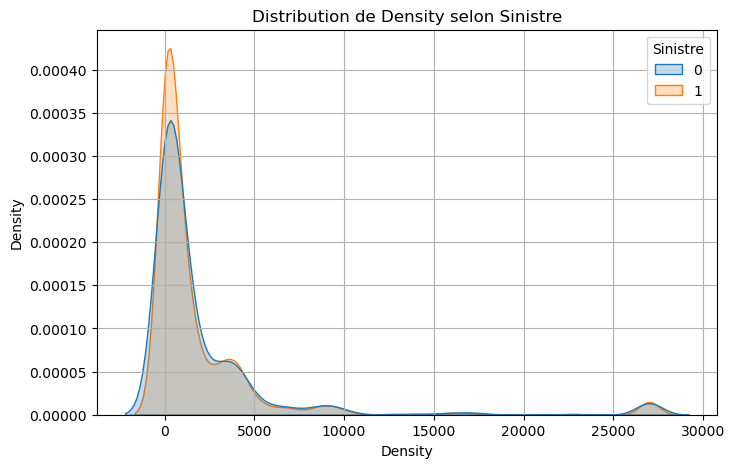

## Analyse de la variable catégorielle : CarBrand



,CarBrand,Effectif,Nombre_sinistres,Taux_de_sinistre
0,Japanese (except Nissan) or Korean,2078,1614,77.67%
1,B12,4200,3250,77.38%
2,B14,131,99,75.57%
3,other,413,308,74.58%
4,B13,539,401,74.40%
5,B2,6805,5033,73.96%
6,Fiat,714,525,73.53%
7,"Mercedes, Chrysler or BMW",833,612,73.47%
8,"Renault, Nissan or Citroen",8942,6565,73.42%
9,B6,1252,919,73.40%


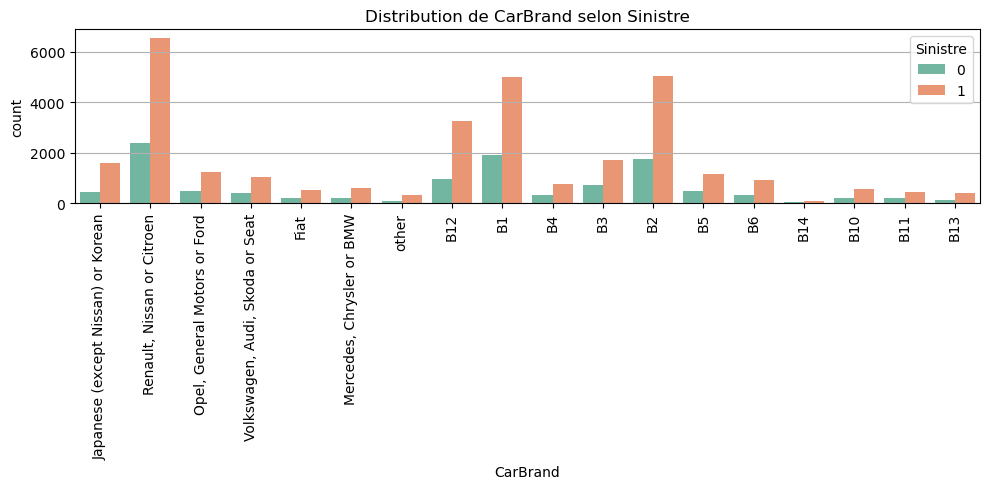

## Analyse de la variable catégorielle : CarGas



,CarGas,Effectif,Nombre_sinistres,Taux_de_sinistre
0,Diesel,21896,16067,73.38%
1,Regular,20729,15203,73.34%


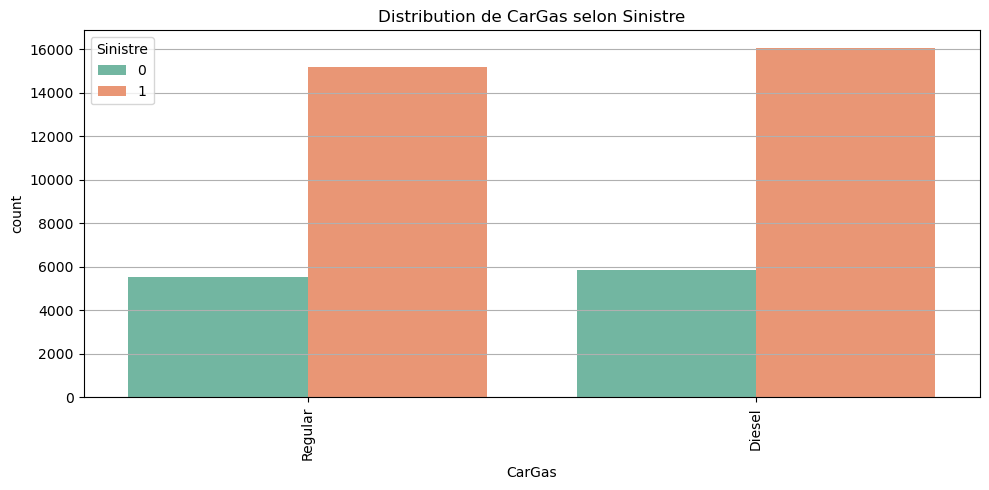

## Analyse de la variable catégorielle : Region



,Region,Effectif,Nombre_sinistres,Taux_de_sinistre
0,Franche-Comte,38,31,81.58%
1,Corse,132,103,78.03%
2,Lorraine,468,364,77.78%
3,Bretagne,3742,2882,77.02%
4,Poitou-Charentes,1600,1218,76.12%
5,Aquitaine,2110,1587,75.21%
6,Alsace,92,69,75.00%
7,Bourgogne,345,258,74.78%
8,Champagne-Ardenne,77,57,74.03%
9,Nord-Pas-de-Calais,1888,1389,73.57%


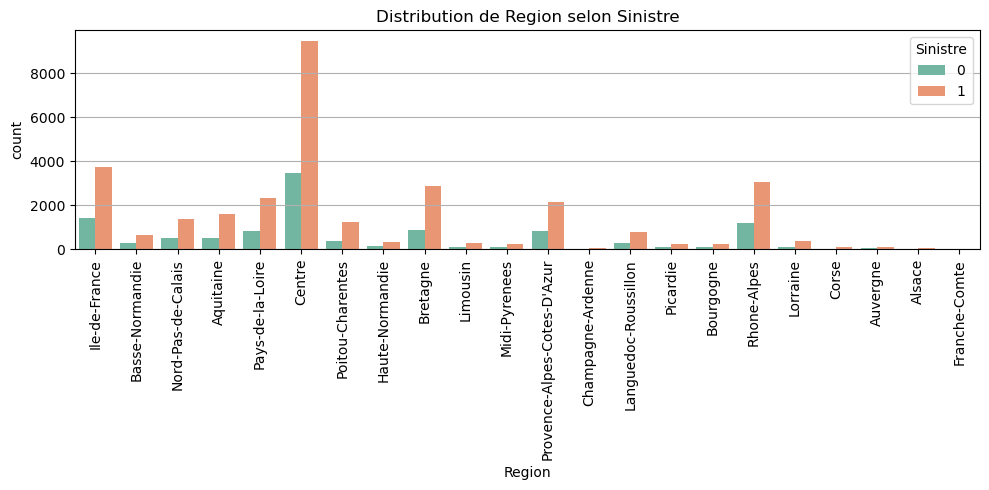

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1,25578,18789,73.46%
1,0,17047,12481,73.22%


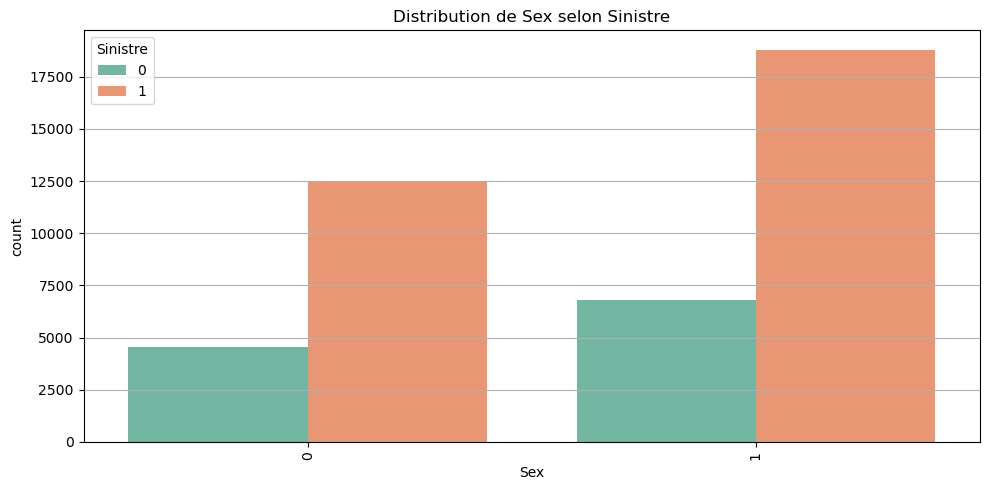

In [35]:
# Liste des variables
vars_num = ['ClaimAmount', 'Exposure', 'power', 'CarAge', 'DriverAge', 'Density']
vars_cat = ['CarBrand', 'CarGas', 'Region', 'Sex']

# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_freMTPL, var)

for var in vars_cat:
    analyse_variable_categorielle(df_freMTPL, var)
